# Proyecto: Análisis del Sentimiento en Criptomonedas y su Relación con el Tipo de Cambio

## Objetivo
Evaluar si existe una correlación significativa entre el sentimiento en el mercado de criptomonedas
(medido por el *Fear & Greed Index*) y el tipo de cambio de monedas emergentes como el sol peruano (PEN/USD).




# **Trabajo 1: Obtención y Análisis de la Base de Datos**
**Curso:** Introducción a Machine Learning con Python

**Grupo:** N° 8

**Integrantes:**

1.   Luis Ángel Alejandro Arrieta Feria
2.   Mirelli Thais Jimenez Pulache
3.   Néstor Julio Rivero Escobar

**Tema:** ¿Existe una correlación significativa entre el sentimiento en el mercado de criptomonedas (medido por el *Fear & Greed Index*) y el tipo de cambio de monedas emergentes como el sol peruano?





## Estructura del Notebook
El notebook se organiza en las siguientes secciones:

1. **Obtención de datos**  
   - Fear & Greed Index  
   - Tipo de cambio PEN/USD (BCRP)  
   - DXY, VIX y BTC  

2. **Unificación de datos**  
   Consolidación de todas las fuentes en un único DataFrame para facilitar el análisis.  

3. **Análisis exploratorio**  
   Estadísticas descriptivas, visualización de tendencias y correlaciones.  

4. **Conclusiones**  
   Discusión sobre los hallazgos y su relevancia en el contexto del mercado cambiario.  

# **Descargar Fear & Greed**


En este apartado se obtiene el índice de "Miedo y Codicia" (*Fear & Greed Index*),
publicado diariamente y utilizado como medida del sentimiento en el mercado de criptomonedas.

**Objetivo:**  
- Incorporar un indicador de sentimiento que complemente los datos financieros.  

**Procedimiento:**  
- Se realiza una consulta a la fuente de datos (API o repositorio en línea).  
- Se estructuran los datos en un DataFrame de pandas para su posterior análisis.

In [ ]:
# ============================
# 1. Importamos librerías
# ============================
import requests  # Para hacer solicitudes HTTP y conectarnos al API del BCRP
import pandas as pd  # Para manejar y analizar datos en tablas
import numpy as np  # Para operaciones matemáticas y numéricas
import yfinance as yf  # Para descargar datos financieros de Yahoo Finance
import matplotlib.pyplot as plt  # Para crear gráficos básicos
import seaborn as sns  # Para visualización estadística avanzada y gráficos mejorados

# Configuraciones de visualización
sns.set_style('whitegrid')  # Estilo de fondo con cuadrícula clara
plt.style.use('seaborn-v0_8-deep')  # Estilo visual con colores definidos por seaborn

# ============================
# 2. Descarga del Fear & Greed Index (Alternative.me API)
# ============================
url_fng = "https://api.alternative.me/fng/?limit=0&format=json"  # URL de la API del Fear & Greed Index
response_fng = requests.get(url_fng)  # Hacemos la solicitud a la API

# Procesamiento directo de los datos
data_fng = response_fng.json()  # Convertimos la respuesta en formato JSON
fng = pd.DataFrame(data_fng['data'])  # Transformamos la parte útil en un DataFrame

# Conversión y limpieza
fng['date'] = pd.to_datetime(fng['timestamp'].astype(int), unit='s')  # Convertimos timestamp a fechas legibles
fng = fng[['date', 'value', 'value_classification']].rename(  # Seleccionamos columnas clave y renombramos
    columns={'value': 'FGI', 'value_classification': 'classification'}
)
fng['FGI'] = pd.to_numeric(fng['FGI'])  # Convertimos la columna FGI a valores numéricos
fng = fng.sort_values('date').set_index('date')  # Ordenamos por fecha y la usamos como índice
fng = fng.loc["2018-06-01":"2025-06-30"]  # Filtramos rango de fechas de interés

# Eliminamos filas con datos faltantes, si las hubiera
fng.dropna(inplace=True)  # Remueve filas vacías

# Vista previa del Fear & Greed Index
display(fng.head(10))  # Mostramos las primeras 10 filas
fng.info()  # Información del DataFrame (tipos de datos, cantidad, etc.)




,FGI,classification
date,,
2018-06-01,24,Extreme Fear
2018-06-02,27,Fear
2018-06-03,40,Fear
2018-06-04,41,Fear
2018-06-05,26,Fear
2018-06-06,42,Fear
2018-06-07,38,Fear
2018-06-08,40,Fear
2018-06-09,39,Fear


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2586 entries, 2018-06-01 to 2025-06-30
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   FGI             2586 non-null   int64 
 1   classification  2586 non-null   object
dtypes: int64(1), object(1)
memory usage: 60.6+ KB


# **Descarga del tipo de cambio PEN/USD desde el BCRP**


En esta sección se descarga la información del tipo de cambio oficial entre
el sol peruano (PEN) y el dólar estadounidense (USD), proporcionado por
el Banco Central de Reserva del Perú (BCRP).  

**Objetivo:**  
- Contar con la serie histórica del tipo de cambio PEN/USD como variable principal del análisis.  

**Procedimiento:**  
- Se utiliza la API del BCRP para obtener los datos.  
- Se formatea la serie temporal y se almacena en un DataFrame.  

In [ ]:

# ============================
# 3. Descarga del Tipo de Cambio (BCRP API)
# ============================

# Parámetros de la consulta
codigo = "PD04640PD"    # Código de la serie: TC Sistema bancario SBS diario - Venta
formato = "json"        # Formato de salida (JSON)
periodo_inicial = "2018-06-01"  # Fecha de inicio de los datos
periodo_final = "2025-06-30"    # Fecha de fin de los datos

# Construcción del url y petición GET
url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codigo}/{formato}/{periodo_inicial}/{periodo_final}"
response = requests.get(url)  # Realizamos la solicitud a la API del BCRP
data = response.json()  # Convertimos la respuesta en JSON

# Procesamiento de los datos
fechas = []     # Lista para almacenar fechas
tc_venta = []   # Lista para almacenar valores del tipo de cambio

for periodo in data['periods']:  # Recorremos cada registro en la respuesta
    fechas.append(periodo['name'])  # Guardamos la fecha
    if periodo['values'][0] != 'n.d.':   # Si el valor no está marcado como 'n.d.' (no disponible)
        tc_venta.append(float(periodo['values'][0]))  # Guardamos el valor como número
    else:
        tc_venta.append(np.nan)  # Si está vacío, colocamos NaN

# Construcción del DataFrame
tc = pd.DataFrame({
    'Fecha': pd.to_datetime(fechas, errors='coerce'),  # Convertimos fechas a formato datetime
    'USD_PEN_Venta': tc_venta  # Colocamos los valores de TC
}).set_index('Fecha')  # Usamos la fecha como índice

# Eliminamos filas con datos faltantes, si las hubiera
tc.dropna(inplace=True)  # Quitamos valores NaN

# Vista previa
display(tc.head(10))  # Mostramos las primeras 10 filas
tc.info()  # Información del DataFrame (tipos de datos y registros)



/tmp/ipython-input-3490362074.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  'Fecha': pd.to_datetime(fechas, errors='coerce'),


,USD_PEN_Venta
Fecha,
2018-06-01,3.273
2018-06-04,3.273
2018-06-05,3.273
2018-06-06,3.261
2018-06-07,3.262
2018-06-08,3.263
2018-06-11,3.267
2018-06-12,3.270
2018-06-13,3.266


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1769 entries, 2018-06-01 to 2025-06-30
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USD_PEN_Venta  1769 non-null   float64
dtypes: float64(1)
memory usage: 27.6 KB


# **Descarga de DXY, VIX y BTC**

Además de las variables principales, se incorporan indicadores financieros adicionales
que pueden influir en la dinámica de los mercados:

- **DXY**: Índice del valor relativo del dólar estadounidense frente a una canasta de monedas.  
- **VIX**: Índice de volatilidad del mercado de opciones del S&P 500, conocido como "índice del miedo".  
- **BTC**: Precio histórico de Bitcoin, principal criptomoneda de referencia.  

**Objetivo:**  
- Ampliar la base de datos con variables macro y financieras que puedan correlacionarse
con el tipo de cambio y el sentimiento en criptomonedas.  

**Procedimiento:**  
- Se consultan APIs o fuentes de datos abiertas.  
- Se generan DataFrames individuales para cada indicador.  

In [ ]:
# ============================
# 4. Descarga de Variables de Control (DXY, VIX, BTC-USD)
# ============================
import yfinance as yf  # Librería para descargar datos financieros desde Yahoo Finance

# Definimos tickers de interés
# DXY -> Índice del dólar (US Dollar Index), ticker en Yahoo Finance: DX-Y.NYB
# VIX -> Índice de volatilidad, ticker: ^VIX
# BTC -> Bitcoin/USD, ticker: BTC-USD
tickers = ['DX-Y.NYB', '^VIX', 'BTC-USD']  # Lista de símbolos a descargar

# Rango de fechas igual al de FGI y TC
start_date = "2018-06-01"  # Fecha inicial
end_date = "2025-06-30"    # Fecha final

# Descargamos precios de cierre
control_df = yf.download(tickers, start=start_date, end=end_date)['Close']
# Descarga datos históricos y selecciona solo la columna "Close" (precio de cierre)

# Renombramos columnas
control_df.rename(columns={
    'DX-Y.NYB': 'DXY',      # Dólar index
    '^VIX': 'VIX',          # Índice de volatilidad
    'BTC-USD': 'BTC_USD'    # Bitcoin en USD
}, inplace=True)

# Eliminamos filas con datos faltantes, si las hubiera
control_df.dropna(inplace=True)  # Remueve registros incompletos

# Vista previa
display(control_df.head(10))  # Mostramos las primeras 10 filas
control_df.info()  # Información del DataFrame (estructura, registros, tipos de datos)




/tmp/ipython-input-2287613545.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  control_df = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  3 of 3 completed


Ticker,BTC_USD,DXY,VIX
Date,,,
2018-06-01,7541.450195,94.190002,13.46
2018-06-04,7514.470215,94.019997,12.74
2018-06-05,7633.759766,93.889999,12.40
2018-06-06,7653.979980,93.660004,11.64
2018-06-07,7678.240234,93.400002,12.13
2018-06-08,7624.919922,93.550003,12.18
2018-06-11,6906.919922,93.580002,12.35
2018-06-12,6582.359863,93.800003,12.34
2018-06-13,6349.899902,93.709999,12.94


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1778 entries, 2018-06-01 to 2025-06-27
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BTC_USD  1778 non-null   float64
 1   DXY      1778 non-null   float64
 2   VIX      1778 non-null   float64
dtypes: float64(3)
memory usage: 55.6 KB


# **Unificación de data**

En este paso se integran todas las fuentes en un único DataFrame maestro
para facilitar el análisis conjunto.

**Objetivo:**  
- Tener un dataset consolidado con todas las variables: Fear & Greed, PEN/USD, DXY, VIX y BTC.  

**Procedimiento:**  
- Se realizan *joins* entre las series temporales utilizando la fecha como clave común.  
- Se manejan valores faltantes (si los hubiera) y se ajusta la frecuencia temporal.  

In [ ]:
# ============================
# 5. Unificación de todas las series en un solo DataFrame
# ============================

# Eliminamos fechas duplicadas en los índices de cada DataFrame
fng = fng.loc[~fng.index.duplicated()]  # Fear & Greed Index
tc = tc.loc[~tc.index.duplicated()]  # Tipo de cambio
control_df = control_df.loc[~control_df.index.duplicated()]  # Variables de control (DXY, VIX, BTC)

# Unimos por índice de fecha y limpiamos datos faltantes
dataset = pd.concat(
    [fng[['FGI']], tc[['USD_PEN_Venta']], control_df],  # Seleccionamos columnas relevantes
    axis=1  # Unimos por columnas
).dropna()  # Quitamos filas con valores faltantes

# Vista previa del dataset final
display(dataset.head(10))  # Mostramos las primeras 10 filas
dataset.info()  # Información del DataFrame final (estructura y tipos de datos)

# ============================
# 6. Exportamos a Excel
# ============================

output_file = "dataset_fgi_tc_peru.xlsx"  # Nombre del archivo de salida
dataset.to_excel(output_file, sheet_name="data")  # Exportamos el DataFrame a Excel

from google.colab import files  # Librería de Colab para descargas
files.download(output_file)  # Descargamos el archivo a la computadora local
print(f"Archivo Excel exportado correctamente: {output_file}")  # Confirmación en consola


,FGI,USD_PEN_Venta,BTC_USD,DXY,VIX
2018-06-01,24.0,3.273,7541.450195,94.190002,13.46
2018-06-04,41.0,3.273,7514.470215,94.019997,12.74
2018-06-05,26.0,3.273,7633.759766,93.889999,12.40
2018-06-06,42.0,3.261,7653.979980,93.660004,11.64
2018-06-07,38.0,3.262,7678.240234,93.400002,12.13
2018-06-08,40.0,3.263,7624.919922,93.550003,12.18
2018-06-11,15.0,3.267,6906.919922,93.580002,12.35
2018-06-12,19.0,3.270,6582.359863,93.800003,12.34
2018-06-13,19.0,3.266,6349.899902,93.709999,12.94
2018-06-14,17.0,3.267,6675.350098,94.769997,12.12


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1011 entries, 2018-06-01 to 2025-06-27
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FGI            1011 non-null   float64
 1   USD_PEN_Venta  1011 non-null   float64
 2   BTC_USD        1011 non-null   float64
 3   DXY            1011 non-null   float64
 4   VIX            1011 non-null   float64
dtypes: float64(5)
memory usage: 47.4 KB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Archivo Excel exportado correctamente: dataset_fgi_tc_peru.xlsx


# **GRÁFICOS**

Con los datos unificados, se procede a realizar un análisis descriptivo y visual.  

**Acciones realizadas:**  
- Cálculo de estadísticas descriptivas (media, varianza, correlaciones).  
- Visualización de tendencias en el tiempo (series históricas).  
- Identificación de posibles patrones o relaciones entre variables.  

**Objetivo:**  
- Obtener una primera comprensión de la dinámica entre el sentimiento del mercado,
el tipo de cambio y los indicadores financieros.  

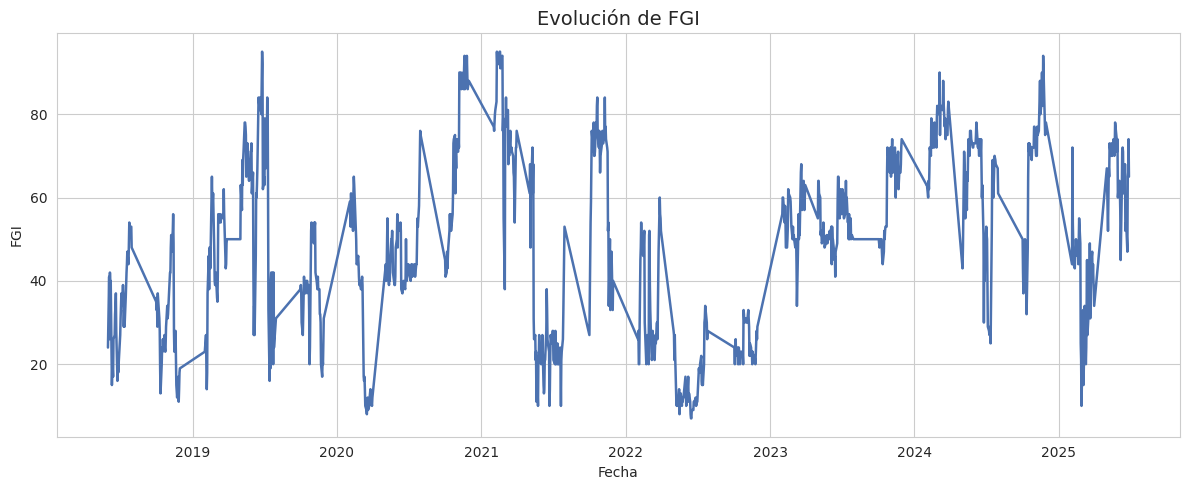

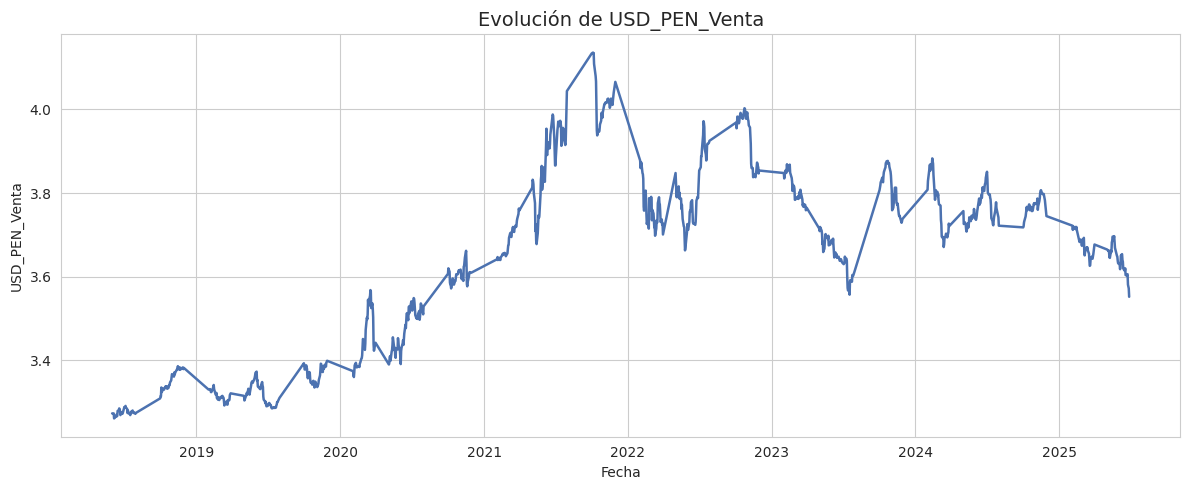

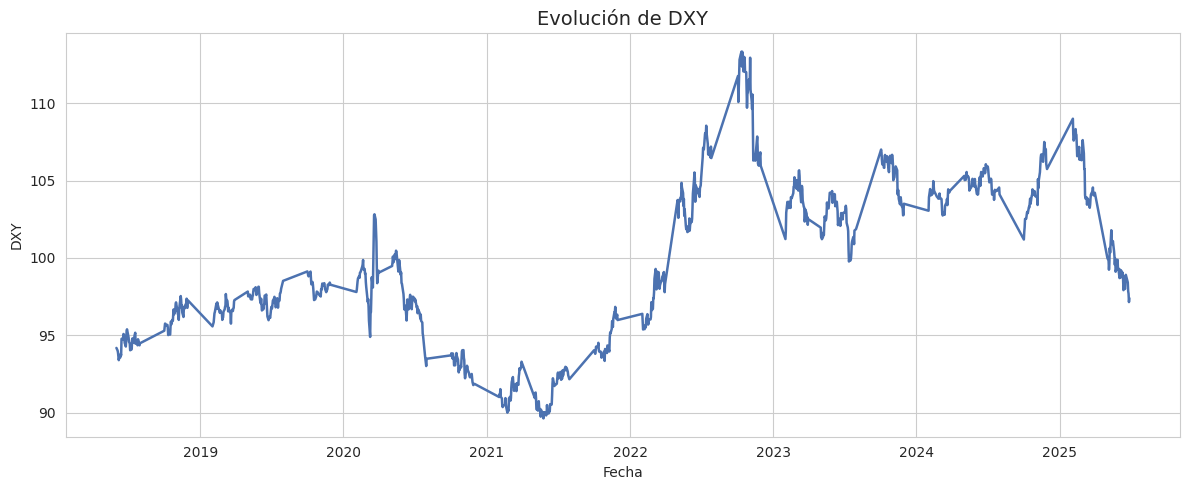

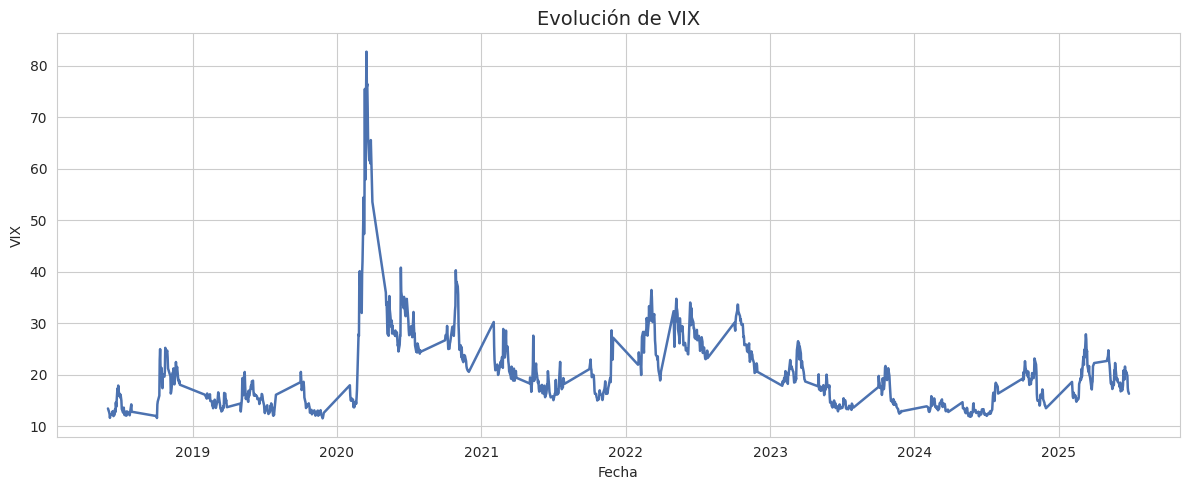

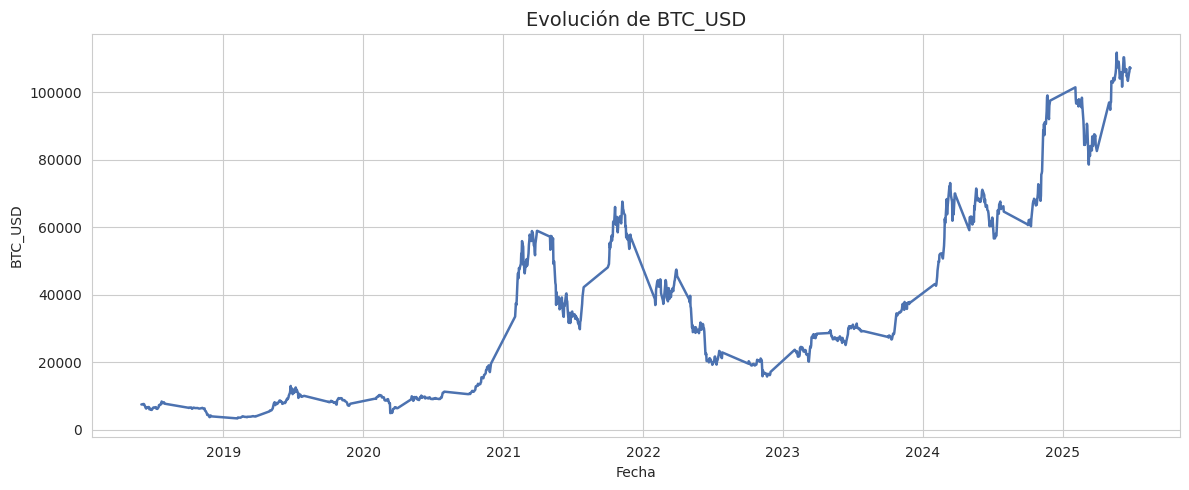

In [ ]:
# ============================
# 7. Gráficos separados para cada serie
# ============================

variables = ["FGI", "USD_PEN_Venta", "DXY", "VIX", "BTC_USD"]  # Lista de variables a graficar

# Recorremos cada variable y generamos un gráfico individual
for var in variables:
    plt.figure(figsize=(12,5))  # Tamaño de la figura
    sns.lineplot(data=dataset, x=dataset.index, y=var, linewidth=1.8)  # Gráfico de líneas
    plt.title(f"Evolución de {var}", fontsize=14)  # Título del gráfico
    plt.xlabel("Fecha")  # Etiqueta del eje X
    plt.ylabel(var)  # Etiqueta del eje Y (nombre de la variable)
    plt.tight_layout()  # Ajusta márgenes automáticamente
    plt.show()  # Muestra el gráfico


***Interpretación:***
- El índice de Fear & Greed tiene un comportamiento muy volátil, entre valores cercanos a 10 (miedo extremo) y picos de 90 (codicia extrema). Esto refleja que el mercado cripto tiene una alta sensibilidad al sentimiento de los inversionistas, mucho más que los mercados tradicionales. Los picos de Extreme Greed a menudo preceden a correcciones de precios, mientras que los periodos de Extreme Fear pueden indicar posibles puntos de compra
- El gráfico de evolución del tipo de cambio evidencia una historia de estabilidad inicial, seguida de una crisis de confianza producto de la pandemia que disparó el valor del dólar a un máximo histórico, y posteriormente un período de corrección y recuperación gradual del sol peruano.
- Al inicio del período analizado, el DXY muestra cierta estabilidad con fluctuaciones en un rango relativamente estrecho. Posteriormente, se observa una clara tendencia alcista que se acentúa significativamente a partir de 2021. El índice alcanza su punto máximo en 2022. Este período coincidió con un entorno macroeconómico global de alta inflación y las respuestas de los bancos centrales, que iniciaron ciclos de aumento de tasas de interés. Después del pico de 2022, el DXY muestra una corrección y una tendencia general a la baja que se extiende hasta 2025.
Un aspecto relevante es que el tipo de cambio en Perú (USD/PEN) alcanzó su máximo histórico a finales de 2021, principalmente por factores de incertidumbre interna (política). Sin embargo, el hecho de que el dólar se estuviera fortaleciendo globalmente (DXY subiendo) en ese mismo período sin duda contribuyó a esa alza y evitó que el sol se recuperara más rápido. La reciente caída del dólar a nivel global en 2025 que vemos en este gráfico, coincide y ayuda a explicar la tendencia a la baja que también se ve en el tipo de cambio USD/PEN en el mismo año.
- El gráfico del VIX muestra la expectativa de volatilidad del mercado. Su pico extremo en 2020 refleja el pánico inicial de la pandemia de COVID-19. Después de ese shock, la volatilidad se mantuvo elevada por un tiempo, para luego disminuir gradualmente hacia niveles más típicos en los últimos años del período analizado, aunque con fluctuaciones. En esencia, el VIX visualiza los momentos de mayor "miedo" e incertidumbre en los mercados financieros globales.
- Lo primero que destaca es la alta volatilidad de Bitcoin y la presencia de tendencias alcistas y bajistas muy pronunciadas a lo largo del tiempo. Esto es característico de los activos de criptomonedas. Se observan períodos de crecimiento explosivo, como a finales de 2020 y durante 2021, donde el precio de Bitcoin aumentó considerablemente, alcanzando picos históricos. Después de los picos, también se aprecian correcciones significativas, donde el precio puede caer drásticamente en un período relativamente corto. Esto ocurrió, por ejemplo, después del pico de 2021 y en otros momentos de euforia seguidos de toma de ganancias o cambios en el sentimiento del mercado. Hacia el final del gráfico (2024-2025), se observa una nueva tendencia alcista marcada, llevando a Bitcoin a nuevos máximos históricos.

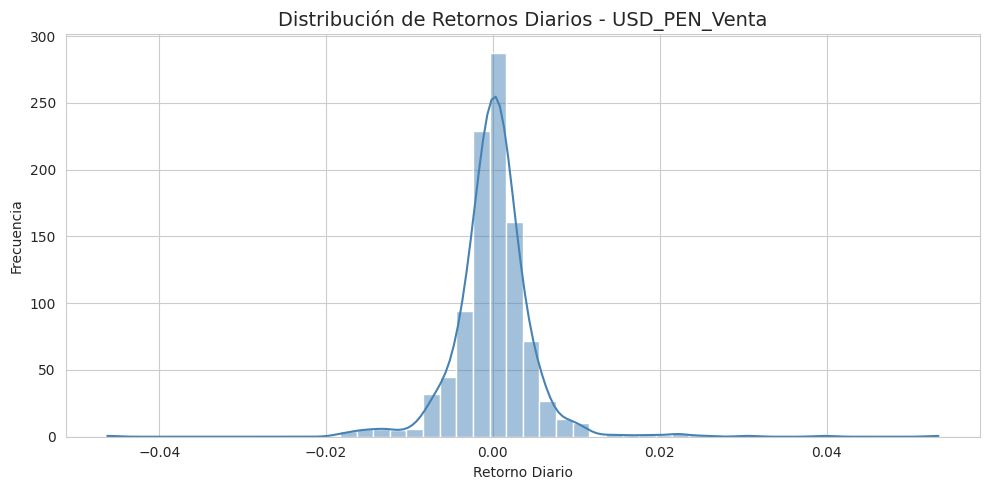

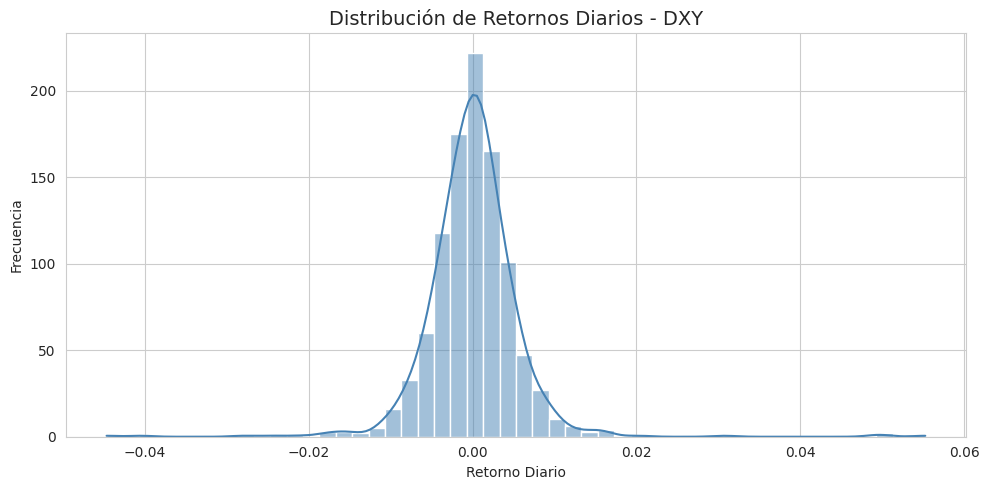

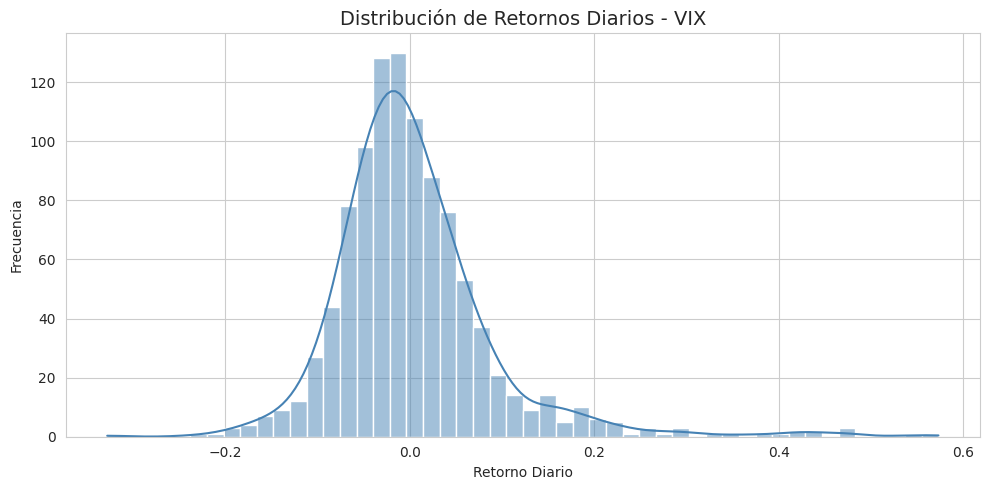

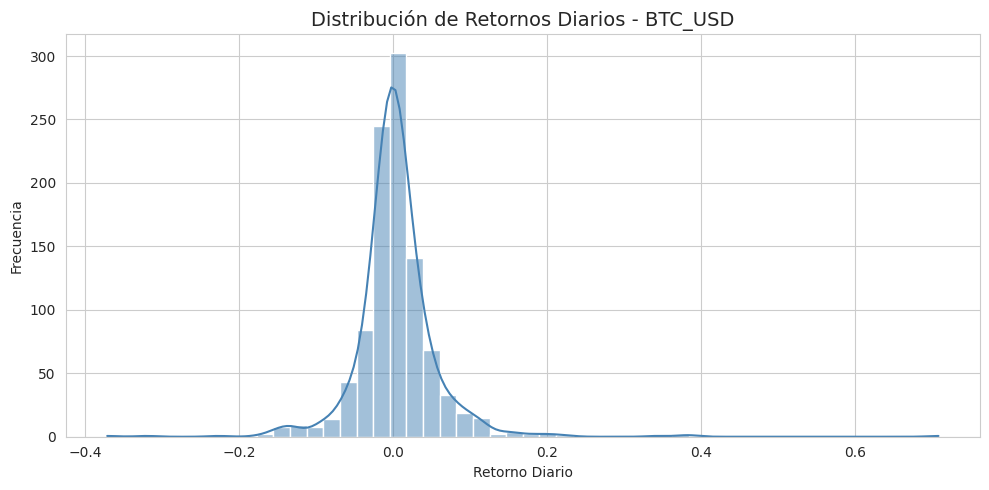

In [ ]:
# ============================
# 8. Histogramas de Retornos Diarios
# ============================

# Calculamos retornos diarios solo para las variables de precio
returns = dataset[["USD_PEN_Venta", "DXY", "VIX", "BTC_USD"]].pct_change().dropna()
# pct_change() calcula el cambio porcentual día a día
# dropna() elimina la primera fila (que queda vacía al calcular retornos)

# Histogramas individuales para cada variable
for var in returns.columns:
    plt.figure(figsize=(10,5))  # Tamaño del gráfico
    sns.histplot(returns[var], kde=True, bins=50, color='steelblue')
    # histplot genera histograma con curva KDE (distribución suavizada)
    plt.title(f"Distribución de Retornos Diarios - {var}", fontsize=14)  # Título del gráfico
    plt.xlabel("Retorno Diario")  # Eje X
    plt.ylabel("Frecuencia")  # Eje Y
    plt.tight_layout()  # Ajusta márgenes automáticamente
    plt.show()  # Muestra el gráfico



***Interpretación:***
- La distribución de los retornos diarios evidencia diferencias importantes en el grado de estabilidad y riesgo de cada activo analizado. En el caso del tipo de cambio USD/PEN, los retornos se concentran fuertemente alrededor de cero, lo que refleja una dinámica estable en el corto plazo. Esto es consistente con la intervención activa del Banco Central de Reserva del Perú, que limita la volatilidad cambiaria para preservar la estabilidad financiera.

- El índice DXY, aunque también presenta una concentración marcada en torno a cero, muestra una dispersión algo mayor que el tipo de cambio local. Ello responde a que el dólar estadounidense se enfrenta a fluctuaciones globales en función de expectativas de política monetaria, inflación y shocks internacionales, aunque sin perder su condición de activo de referencia y reserva.

- En contraste, el VIX presenta una distribución más amplia y con colas más pesadas, lo que evidencia episodios recurrentes de alta volatilidad. Esta característica se explica porque el VIX refleja directamente las expectativas de riesgo e incertidumbre en los mercados financieros globales, por lo que responde con fuerza a eventos inesperados como crisis sanitarias, tensiones geopolíticas o inestabilidad macroeconómica.

- El caso del Bitcoin es el más extremo. Su histograma presenta retornos dispersos y frecuentes valores alejados de cero, confirmando que se trata de un activo de elevada volatilidad. Esta dinámica obedece tanto a la falta de regulación en el mercado cripto como a su carácter especulativo, lo que lo convierte en un activo atractivo para inversionistas con alta tolerancia al riesgo, pero poco comparable con la estabilidad de los mercados tradicionales.

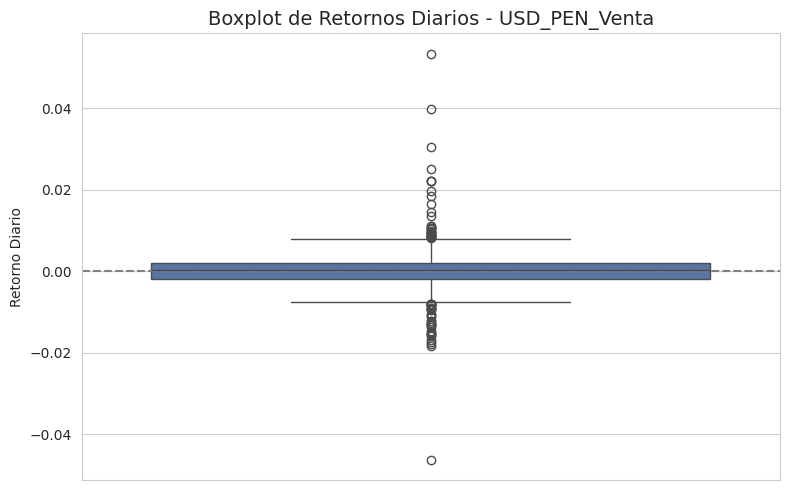

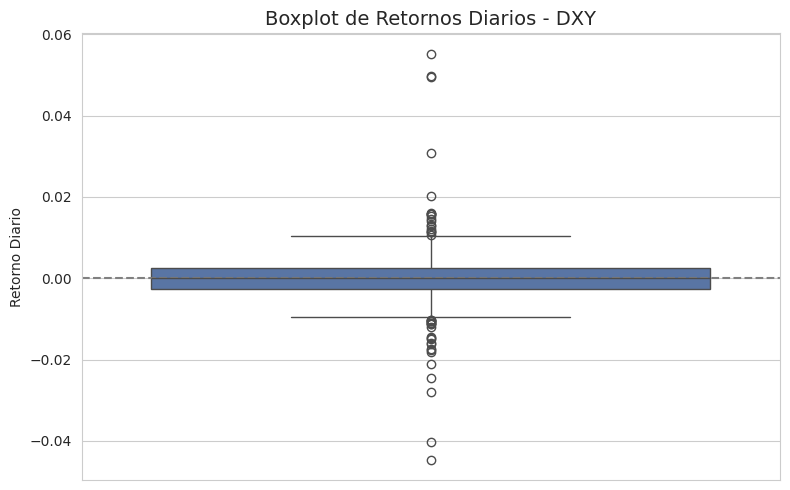

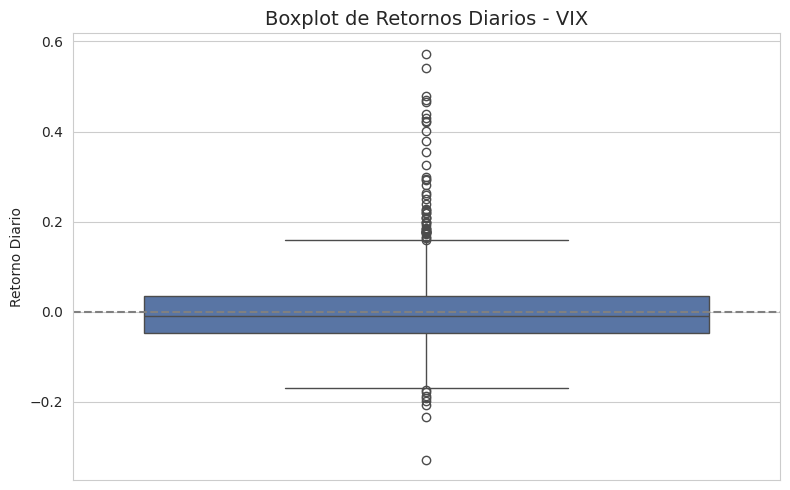

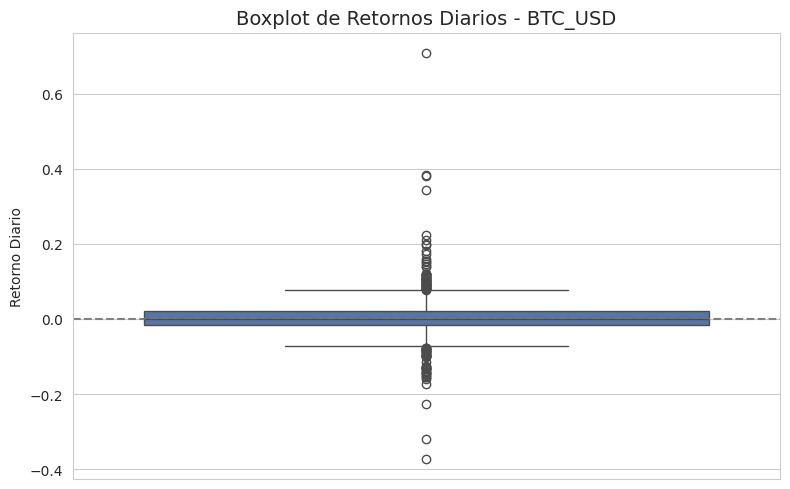

In [ ]:
# ============================
# 9. Boxplots individuales de retornos diarios
# ============================

# Recorremos cada variable de retornos para graficar su boxplot
for var in returns.columns:
    plt.figure(figsize=(8,5))  # Tamaño del gráfico
    sns.boxplot(y=returns[var])  # Genera boxplot de la variable
    plt.title(f"Boxplot de Retornos Diarios - {var}", fontsize=14)  # Título del gráfico
    plt.ylabel("Retorno Diario")  # Etiqueta del eje Y
    plt.axhline(0, color='grey', linestyle='--')  # Línea horizontal en cero como referencia
    plt.tight_layout()  # Ajusta márgenes automáticamente
    plt.show()  # Muestra el gráfico


***Interpretación:***
- Los boxplots permiten visualizar la dispersión y la presencia de valores extremos en los retornos diarios. En el USD/PEN, el gráfico muestra una caja muy estrecha y con pocos outliers, lo que refleja la baja volatilidad del tipo de cambio peruano. Esto es coherente con la política cambiaria del BCRP, que interviene en el mercado para suavizar choques externos y dar confianza a los agentes económicos.

- En el DXY, la caja es igualmente estrecha aunque ligeramente más amplia que la del USD/PEN, con algunos valores atípicos. Esto sugiere que, aunque el dólar a nivel global es un activo estable, puede experimentar movimientos bruscos cuando las condiciones macroeconómicas internacionales cambian, especialmente en periodos de ajustes en las tasas de interés de la Reserva Federal.

- El VIX presenta una caja más amplia y con numerosos valores extremos, lo que confirma su carácter altamente sensible a episodios de crisis. La presencia recurrente de outliers refleja que los mercados globales enfrentan shocks de incertidumbre de manera frecuente, y que estos se manifiestan en movimientos significativos en la expectativa de volatilidad.

- El Bitcoin, nuevamente, sobresale como el activo más volátil. Su boxplot presenta una dispersión considerablemente mayor y abundantes valores extremos, lo que evidencia la magnitud de sus fluctuaciones diarias. Este comportamiento se explica por la naturaleza descentralizada del mercado cripto y su dependencia del sentimiento especulativo de los inversionistas, factores que lo hacen mucho más riesgoso en comparación con los activos tradicionales.

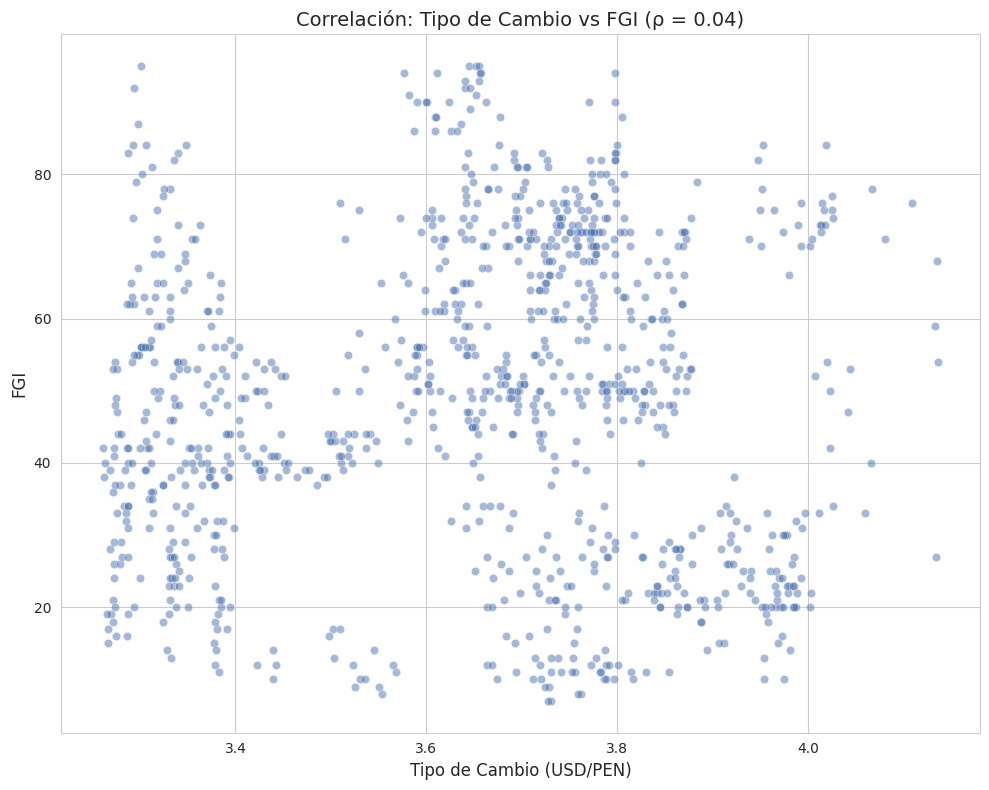

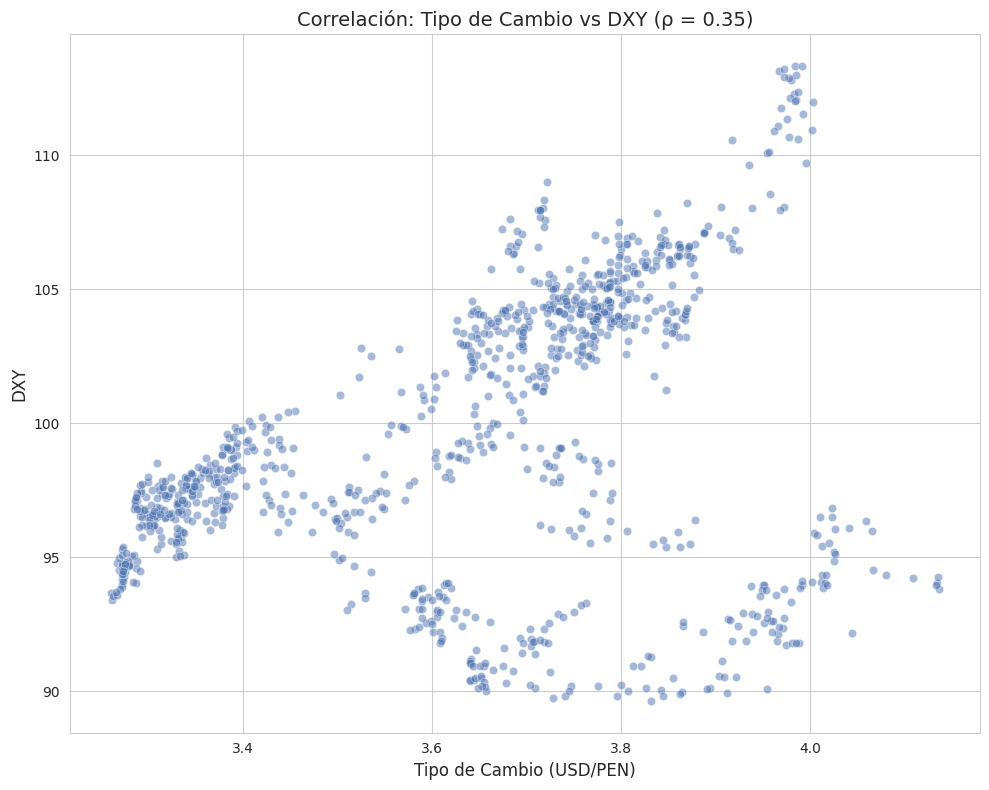

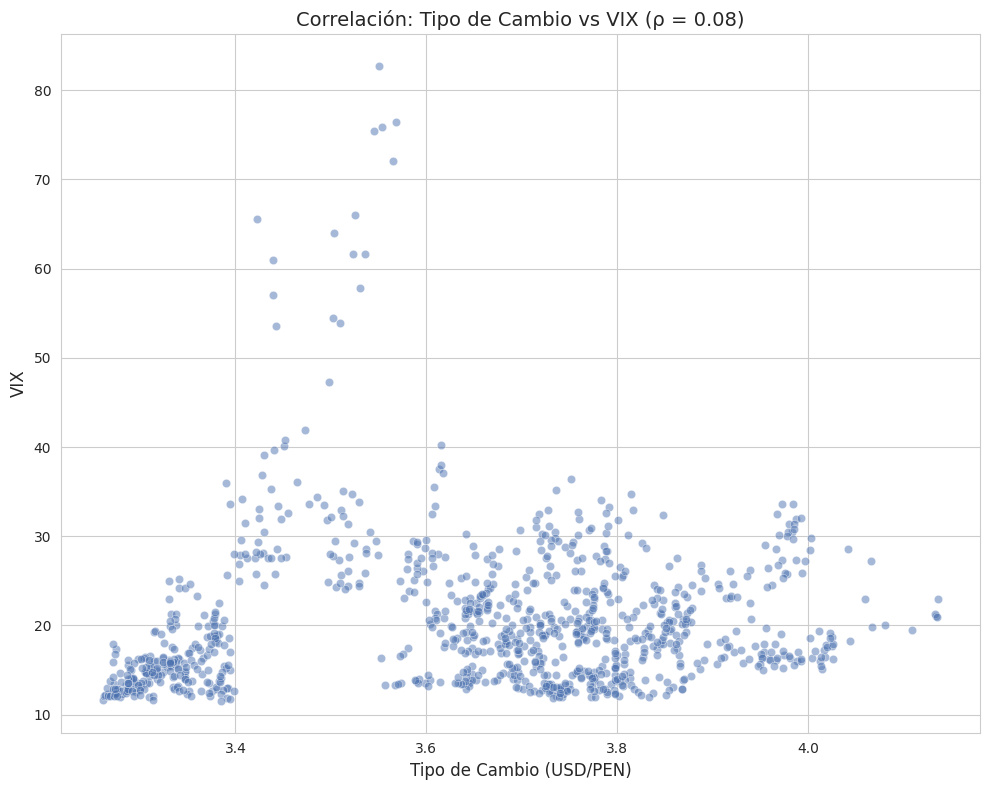

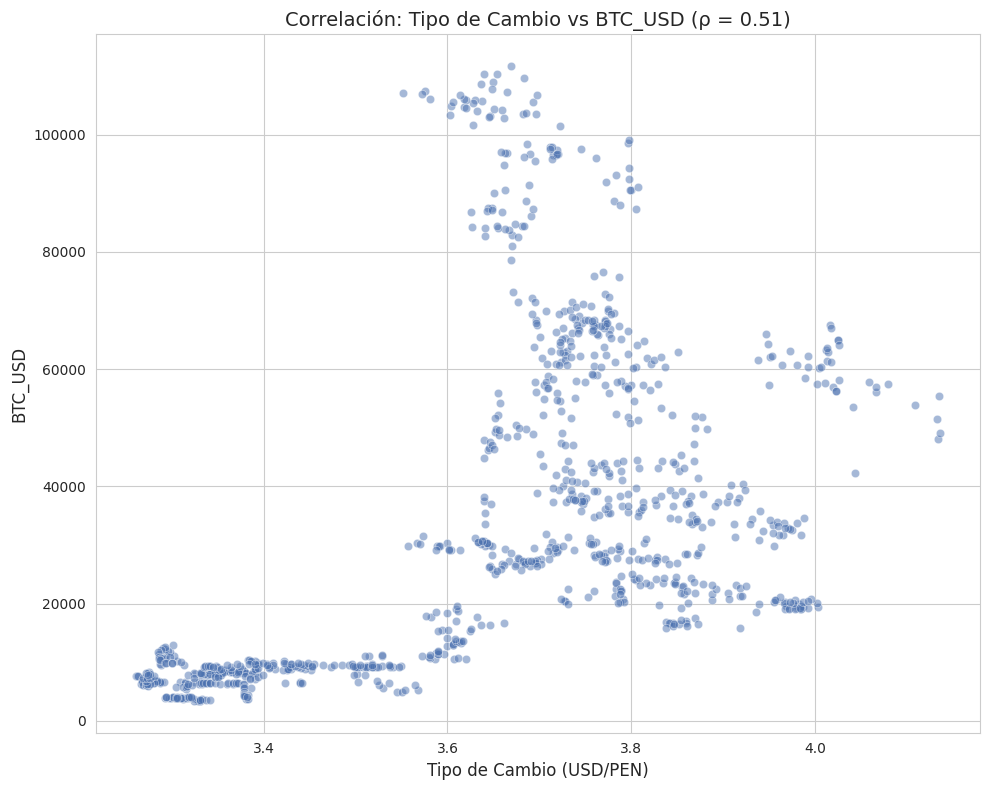

In [ ]:
# ============================
# 10. Gráficos de dispersión y correlación (variables en nivel)
# ============================

comparaciones = ["FGI", "DXY", "VIX", "BTC_USD"]  # Variables a comparar contra el tipo de cambio

# Recorremos cada variable para generar scatterplots
for var in comparaciones:
    plt.figure(figsize=(10, 8))  # Tamaño del gráfico

    # Gráfico de dispersión entre tipo de cambio y la variable en nivel
    sns.scatterplot(x=dataset["USD_PEN_Venta"], y=dataset[var], alpha=0.5)

    # Cálculo de correlación de Pearson entre el tipo de cambio y la variable
    corr = dataset[["USD_PEN_Venta", var]].corr().iloc[0, 1]

    # Etiquetas de los ejes
    plt.xlabel("Tipo de Cambio (USD/PEN)", fontsize=12)
    plt.ylabel(var, fontsize=12)

    # Título con el valor de la correlación
    plt.title(f"Correlación: Tipo de Cambio vs {var} (ρ = {corr:.2f})", fontsize=14)

    # Cuadrícula y ajuste automático de márgenes
    plt.grid(True)
    plt.tight_layout()

    # Mostramos el gráfico
    plt.show()



***Interpretación:***
- Los gráficos de dispersión entre el tipo de cambio USD/PEN y las demás variables permiten evaluar el grado de relación entre ellas. En el caso del FGI, se observa una dispersión muy amplia y sin tendencia definida, lo que indica que el sentimiento de los inversionistas en el mercado cripto no guarda relación significativa con la evolución del tipo de cambio en Perú.

- En contraste, la relación con el DXY es más clara. Se aprecia una correlación positiva, lo que significa que cuando el dólar se fortalece a nivel global, también se deprecia el sol peruano. Este hallazgo es relevante porque confirma que la dinámica del tipo de cambio en Perú no solo responde a factores internos, sino que también está influenciada por las condiciones monetarias y financieras internacionales.

- En el caso del VIX, la dispersión es más aleatoria y con un nivel bajo de correlación. Esto implica que, aunque los episodios de alta volatilidad global pueden afectar al tipo de cambio en momentos de crisis, en términos generales no existe una relación sistemática entre ambas variables.

- Finalmente, la comparación con el Bitcoin revela prácticamente ausencia de correlación. Esto confirma que el mercado cripto funciona bajo dinámicas propias, ajenas al comportamiento de las monedas tradicionales y a los indicadores macroeconómicos globales.

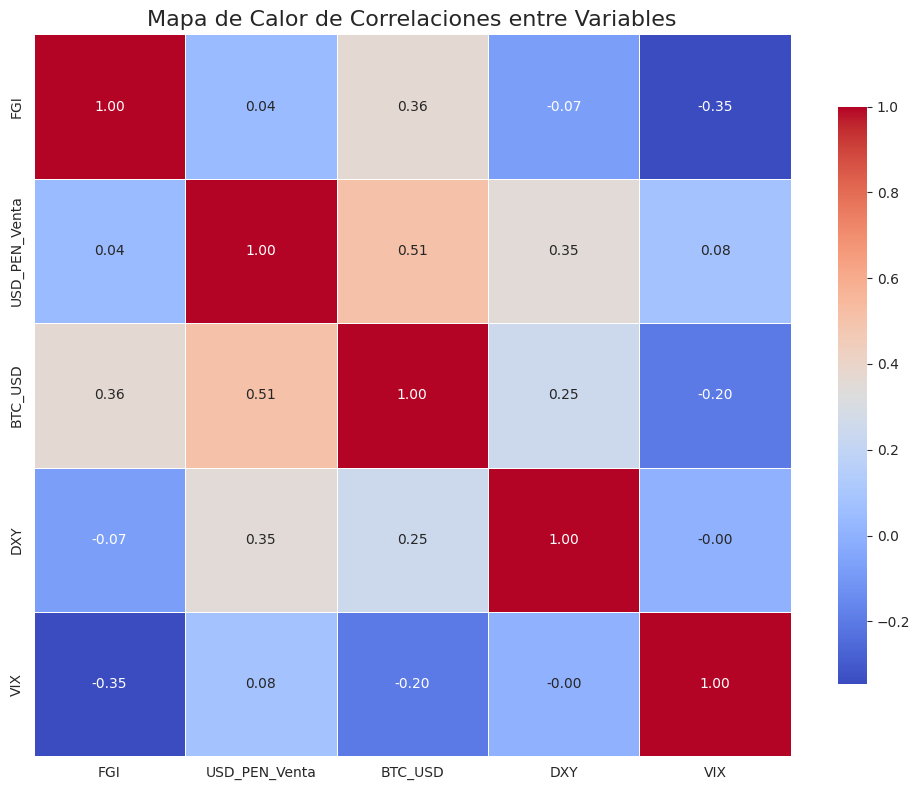

In [ ]:
# ============================
# 11. Mapa de Calor de Correlaciones (niveles)
# ============================

# Calculamos la matriz de correlación entre todas las variables en nivel
corr_matrix = dataset.corr()

plt.figure(figsize=(10, 8))  # Tamaño del gráfico

# Generamos el mapa de calor
sns.heatmap(
    corr_matrix,        # Matriz de correlaciones
    annot=True,         # Mostrar valores dentro de cada celda
    cmap='coolwarm',    # Escala de colores (azul = negativo, rojo = positivo)
    fmt=".2f",          # Formato de los valores (2 decimales)
    linewidths=.5,      # Grosor de las líneas divisorias
    cbar_kws={"shrink": 0.8}  # Ajuste del tamaño de la barra de colores
)

plt.title('Mapa de Calor de Correlaciones entre Variables', fontsize=16)  # Título
plt.tight_layout()  # Ajuste automático de márgenes
plt.show()  # Mostrar gráfico



***Interpretación:***
- El mapa de calor de correlaciones sintetiza las relaciones estadísticas entre todas las variables analizadas. El resultado más relevante es la correlación positiva entre el tipo de cambio USD/PEN y el índice DXY. Esto confirma que la evolución del sol peruano está influida por la fortaleza del dólar en los mercados internacionales, un hallazgo consistente con la literatura económica sobre economías abiertas y dolarizadas.

- La relación del tipo de cambio con el VIX aparece débil, lo que sugiere que la volatilidad global no se traslada directamente al mercado cambiario peruano, aunque en episodios de crisis extremas puede intensificar movimientos temporales.

- El Bitcoin muestra correlaciones muy bajas o nulas con todas las variables tradicionales, lo que refuerza la idea de que opera como un activo independiente y altamente especulativo, con una dinámica que responde más al comportamiento interno del mercado cripto que a variables macroeconómicas globales.

- Finalmente, el Fear & Greed Index presenta correlaciones mínimas con las demás variables, lo que implica que es un indicador útil para analizar el sentimiento específico de los inversionistas en criptomonedas, pero con poca relevancia para explicar la evolución de los mercados tradicionales como el cambiario o de renta fija.